# Two-Mic Speaker Angle Detection (Calibration + Windowed Analysis)

This notebook:
- Loads `self.wav` (single speaker at 0°) to estimate effective mic spacing.
- Loads `conversation.wav` (you at 0°, another at unknown angle, possibly overlapping).
- Segments `conversation.wav` into 0.5s windows with 0.125s hop, finds all cross-correlation peaks, discards 'self' peak, estimates and plots the angle of the non-self speaker vs time.

**Required files:**
- `self.wav` (calibration, stereo, 48kHz)
- `conversation.wav` (analysis, stereo, 48kHz)

---

In [1]:
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
from scipy.signal import correlate, find_peaks

fs = 48000
c = 343

# ---- 1. Calibration: Estimate mic spacing with self.wav ----
self_audio, fs_self = sf.read('self.wav')
assert fs_self == fs
assert self_audio.shape[1] == 2

self_left = self_audio[:, 1]
self_right = self_audio[:, 0]

# Use only a central segment if desired
N = len(self_left)
calib_region = slice(N//4, 3*N//4)  # central half

corr = correlate(self_left[calib_region], self_right[calib_region], mode='full')
lags = np.arange(-len(self_left[calib_region])+1, len(self_right[calib_region]))
peak_idx = np.argmax(np.abs(corr))
calib_lag = lags[peak_idx]  # samples
print(f'Calibration: lag = {calib_lag} samples')

# Compute effective mic spacing d_eff
delay_sec = calib_lag / fs
d_eff = abs(delay_sec) * c  # meters
print(f'Estimated mic spacing: {d_eff*100:.2f} cm')

# Remember sign: positive lag means left leads right (source closer to left mic, i.e. 0 deg).

Calibration: lag = 29 samples
Estimated mic spacing: 20.72 cm


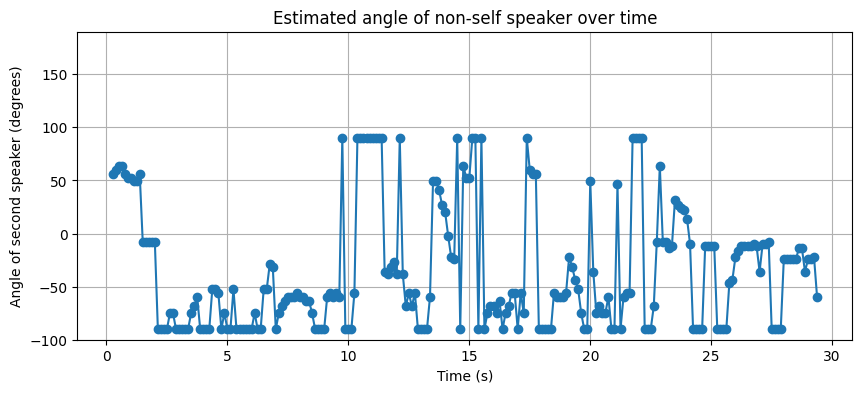

In [2]:
    # ---- 2. Angle Detection in conversation.wav ----
conv_audio, fs_conv = sf.read('conversation.wav')
assert fs_conv == fs
assert conv_audio.shape[1] == 2

left = conv_audio[:, 0]
right = conv_audio[:, 1]

win_size = int(0.5 * fs)   # 0.5s
hop_size = int(0.125 * fs) # 0.125s
n_windows = (len(left) - win_size) // hop_size + 1

times = []
angles = []
lags_all = []

for i in range(n_windows):
    start = i * hop_size
    end = start + win_size
    seg_left = left[start:end]
    seg_right = right[start:end]
    
    corr = correlate(seg_left, seg_right, mode='full')
    lags = np.arange(-len(seg_left)+1, len(seg_right))
    
    # Find peaks in abs(corr)
    abs_corr = np.abs(corr)
    peaks, _ = find_peaks(abs_corr, height=np.max(abs_corr)*0.2)  # take peaks above 20% max
    peak_lags = lags[peaks]
    peak_vals = abs_corr[peaks]
    
    # Remove lag closest to calib_lag (self) -- allow +/-2 sample tolerance
    self_mask = np.abs(peak_lags - calib_lag) <= 2
    nonself_lags = peak_lags[~self_mask]
    nonself_vals = peak_vals[~self_mask]
    
    # If another strong lag remains, take the highest peak; else, set as NaN
    if len(nonself_lags) > 0:
        main_idx = np.argmax(nonself_vals)
        lag = nonself_lags[main_idx]
        # Angle calc:
        sin_theta = (lag / fs) * c / d_eff
        # Clamp for safety
        sin_theta = np.clip(sin_theta, -1, 1)
        theta_deg = np.degrees(np.arcsin(sin_theta))
    else:
        lag = np.nan
        theta_deg = np.nan
    times.append((start + win_size//2)/fs)  # midpoint of window, seconds
    angles.append(theta_deg)
    lags_all.append(lag)

angles = np.array(angles)
times = np.array(times)

plt.figure(figsize=(10,4))
plt.plot(times, angles, marker='o')
plt.xlabel('Time (s)')
plt.ylabel('Angle of second speaker (degrees)')
plt.title('Estimated angle of non-self speaker over time')
plt.ylim(-100, 190)
plt.grid(True)
plt.show()